In [184]:
from sklearn.datasets import fetch_openml, make_classification, make_regression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
# https://erdogant.github.io/distfit/pages/html/Parametric.html

In [168]:
adult = fetch_openml('adult')
X = adult['data']
y = adult['target']
X.info()

c:\Users\vitos\anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1.
  warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  category
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  float64 
 3   education       48842 non-null  category
 4   education-num   48842 non-null  float64 
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capitalgain     48842 non-null  category
 11  capitalloss     48842 non-null  category
 12  hoursperweek    48842 non-null  category
 13  native-country  47985 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [179]:
num_features = X.select_dtypes(include='number').columns.to_list()
cat_features = X.select_dtypes(exclude='number').columns.to_list()

cardinalitites = [
    X[f].nunique()
    for f in cat_features
]

max_one_hot = 10
oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]

In [203]:
col_transformer = ColumnTransformer([
    ('oh_cat_features',make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore')), oh_cat_features),
    ('ord_cat_features',make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), ord_cat_features),
    ('num_features', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), num_features),
])

fu_base = FeatureUnion([
    (
        'fu_col', 
        col_transformer
    )
])

In [181]:
# Baseline
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

rf_base = make_pipeline(
    fu_base,
    RandomForestClassifier()
) 
cross_validate(rf_base, X_train, y_train, scoring='accuracy', cv=5, return_train_score=True)

{'fit_time': array([5.7580235 , 5.25667691, 5.02047253, 4.90932083, 5.76785469]),
 'score_time': array([0.4186573 , 0.32849145, 0.37414646, 0.32984018, 0.41532969]),
 'test_score': array([0.83689718, 0.82461328, 0.83210101, 0.83084973, 0.82584461]),
 'train_score': array([0.99945969, 0.999545  , 0.99954502, 0.99960189, 0.99951658])}

In [183]:
rf_base.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('fu_col',
                                                 ColumnTransformer(transformers=[('oh_cat_features',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['age',
                                                                                   'workclass',
                                                                                   'marital-status',
                                                                                   'relationship',
                                                                                   'race',
                                                                                   'sex',
                                                                                   'capitalgain',
                                                                                   'c...
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('ordinalencoder',
                                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                  unknown_value=-1))]),
                                                                                  ['education',
                                                                                   'occupation',
                                                                                   'native-country']),
                                                                                 ('num_features',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['fnlwgt',
                                                                                   'education-num'])]))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [185]:
y_pred = rf_base.predict(X_test)

accuracy_score(y_test, y_pred)

0.8268167860798362

<AxesSubplot:>

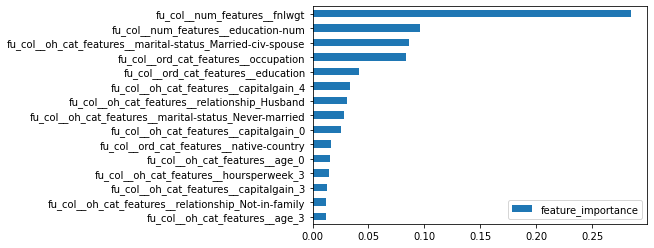

In [250]:
feature_importances = pd.DataFrame(
    rf_base.steps[-1][1].feature_importances_,
    index=rf_base[:-1].get_feature_names_out(),
    columns=['feature_importance']
).sort_values('feature_importance', ascending=False)
feature_importances.sort_values('feature_importance')[-15:].plot(kind='barh')


In [211]:
# Feature Selection

train_size = X_train.shape[0]

# Generate random features
x_norm = pd.DataFrame(np.random.normal(size=(train_size,1)), columns=['x_norm']) 
# x_rand = pd.DataFrame(np.random.random(size=(train_size,1)), columns=['x_rand'])
# x_exp = pd.DataFrame(np.random.exponential(size=(train_size,1)), columns=['x_exp'])
# x_choice = pd.DataFrame(np.random.choice([i for i in range(10)], size=(train_size,1)), columns=['x_choice'])
x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(train_size,1))  , columns=['x_binom'])

X_random = pd.concat(
    [x_norm,
    # x_rand,
    # x_exp,
    # x_choice,
    x_binom
    ], axis=1)

random_features = X_random.columns.to_list()



['x_norm', 'x_binom']

In [89]:

# Optionally
# shuffled_features = X.columns.to_list()[:2]

# shuffled_num_features = X[shuffled_features].select_dtypes(include='number').columns.to_list()
# shuffled_cat_features = X[shuffled_features].select_dtypes(exclude='number').columns.to_list()

# shuffled_cardinalitites = [
#     X[f].nunique()
#     for f in cat_features
# ]
# shuffled_oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
# shuffled_ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]


In [284]:
X_train_noise= pd.concat([
    X_train.reset_index(drop=True),
    X_random.reset_index(drop=True)
], axis=1)

X_train_noise.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,x_norm,x_binom
0,0,NaN,80564.0,HS-grad,9.0,Never-married,NaN,Own-child,White,Male,0,0,3,United-States,2.626486,1
1,3,State-gov,254285.0,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2,4,Germany,1.240100,1
2,4,Private,107196.0,HS-grad,9.0,Widowed,Tech-support,Not-in-family,White,Female,0,0,0,United-States,0.129020,1
3,3,Private,135525.0,Some-college,10.0,Widowed,Adm-clerical,Unmarried,White,Female,0,0,2,United-States,0.792893,1
4,1,Private,188900.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,2,United-States,0.795255,0


In [223]:
random_col_transformer = ColumnTransformer([
    ('random_features', 'passthrough', random_features)  
])


fu_noise = FeatureUnion([
    (
        'fu_col', 
        col_transformer
    ),
    (
        'fu_random_col',
        random_col_transformer
    ),
])



In [226]:
rf_noise = make_pipeline(
    fu_noise,
    RandomForestClassifier()
) 
cross_validate(rf_noise, X_train_noise, y_train, scoring='accuracy', cv=5, return_train_score=True)

{'fit_time': array([5.87110233, 6.58772349, 6.37880182, 6.10738325, 6.38547826]),
 'score_time': array([0.4573431 , 0.36175871, 0.36037731, 0.40248442, 0.39103413]),
 'test_score': array([0.84883985, 0.84235669, 0.84256626, 0.84734387, 0.8441588 ]),
 'train_score': array([1.        , 0.99994313, 1.        , 0.99997156, 1.        ])}

In [295]:
from sklearn.model_selection import KFold
from sklearn.base import clone

rf_noise = make_pipeline(
    fu_noise,
    RandomForestClassifier()
) 

def compute_cv_feature_importances(pipeline, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits)

    feature_importances = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline_ = clone(pipeline)

        pipeline_.fit(X_train, y_train)

        feature_importances.append(
            pipeline_.steps[-1][1].feature_importances_
        )
      
    return  feature_importances
        
feature_importances = compute_cv_feature_importances(rf_noise, X_train_noise, y_train)

TRAIN: [ 8792  8793  8794 ... 43954 43955 43956] TEST: [   0    1    2 ... 8789 8790 8791]
TRAIN: [    0     1     2 ... 43954 43955 43956] TEST: [ 8792  8793  8794 ... 17581 17582 17583]
TRAIN: [    0     1     2 ... 43954 43955 43956] TEST: [17584 17585 17586 ... 26372 26373 26374]
TRAIN: [    0     1     2 ... 43954 43955 43956] TEST: [26375 26376 26377 ... 35163 35164 35165]
TRAIN: [    0     1     2 ... 35163 35164 35165] TEST: [35166 35167 35168 ... 43954 43955 43956]


In [299]:
test_size = X_test.shape[0]

x_norm = pd.DataFrame(np.random.normal(size=(test_size,1)), columns=['x_norm']) 
x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(test_size,1))  , columns=['x_binom'])
X_random_test = pd.concat(
    [x_norm,x_binom],
     axis=1
)

X_test_noise= pd.concat([
    X_test.reset_index(drop=True),
    X_random_test.reset_index(drop=True)
], axis=1)

rf_noise.fit(X_train_noise, y_train)
y_pred = rf_noise.predict(X_test_noise)

accuracy_score(y_test, y_pred)

0.8374616171954964

<AxesSubplot:>

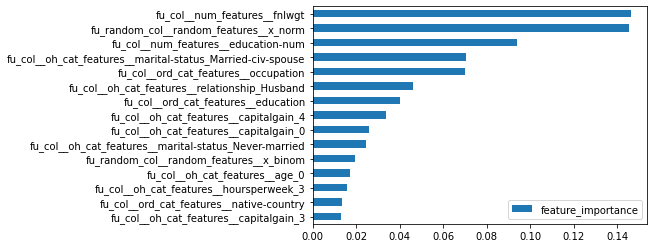

In [307]:
# feature_importances_noise = pd.DataFrame(
#     rf_noise.steps[-1][1].feature_importances_,
#     index=rf_noise[:-1].get_feature_names_out(),
#     columns=['feature_importance']
# ).sort_values('feature_importance', ascending=False)
# feature_importances_noise.sort_values('feature_importance')[-15:].plot(kind='barh')

feature_importances_noise = pd.DataFrame(
    np.mean(feature_importances, axis=0),
    index=rf_noise[:-1].get_feature_names_out(),
    columns=['feature_importance']
).sort_values('feature_importance', ascending=False)
feature_importances_noise.sort_values('feature_importance')[-15:].plot(kind='barh')


In [304]:
feature_names = list(rf_noise[:-1].get_feature_names_out())

In [305]:
random_feature_names = [f for f in feature_names if 'random' in f]
random_feature_idx = [feature_names.index(f) for f in feature_names if 'random' in f]


[53, 54]

In [308]:
threshold = feature_importances_noise.loc[random_feature_names,:].values.max()
selected_feature_importances = feature_importances_noise[feature_importances_noise['feature_importance']>threshold]

In [309]:
selected_feature_importances

,feature_importance
fu_col__num_features__fnlwgt,0.146456
fu_random_col__random_features__x_norm,0.145499
fu_col__num_features__education-num,0.093776


In [310]:
# X_train_noise
selected_features = selected_feature_importances.index.to_list()
selected_feature_idx = [feature_names.index(f) for f in selected_features]

selected_col_transformer = ColumnTransformer([
    ('selected_features', 'passthrough', selected_feature_idx)  
])    

rf_selected = make_pipeline(
    fu_noise,
    selected_col_transformer,
    RandomForestClassifier()
) 
cross_validate(rf_selected, X_train_noise, y_train, scoring='accuracy', cv=5, return_train_score=True)


{'fit_time': array([ 6.97000265,  7.7524631 ,  6.83869815, 12.94024539, 12.17639375]),
 'score_time': array([0.37040758, 0.41420579, 0.34041381, 0.76188993, 0.69438338]),
 'test_score': array([0.75090992, 0.75261601, 0.75133659, 0.75338414, 0.75304288]),
 'train_score': array([0.99988625, 0.99994313, 0.99997156, 0.99985782, 0.99988625])}